In [1]:
using ParticleFilters
using POMCPOW
using MCTS

include("../src/geosteering.jl");
include("../src/mdp.jl");
include("../src/pomdp.jl");
include("../src/utils.jl");

#set seed for reproducibility
rng = MersenneTwister(1) 

MersenneTwister(1)

## Case with tiny drifting probability

In [2]:
#initialize the POMDP model
gs = initialize_pomdp(
    rng=rng, size=(5, 5), 
    base_amplitude=1.0, 
    base_frequency=1.0,
    obs_tol = 1,
    target_thickness=2.0, 
    vertical_shift=2.0,
    drift_prob=0.1) #some drift_prob

GeoSteeringPOMDP
  size: Tuple{Int64, Int64}
  base_amplitude: Float64 1.0
  base_frequency: Float64 1.0
  amplitude_variation: Float64 0.5
  frequency_variation: Float64 0.05
  phase: Float64 0.3
  vertical_shift: Float64 2.0
  target_thickness: Float64 2.0
  drift_prob: Float64 0.1
  discount: Float64 0.95
  reward_target: Float64 0.0
  reward_offtarget: Float64 -100.0
  reward_goal: Float64 1000.0
  obs_tol: Int64 1
  rng: MersenneTwister
  target_zone: Set{SVector{2, Int64}}
  shale_zone: Set{SVector{2, Int64}}
  nontarget_zone: Set{SVector{2, Int64}}
  terminal_zone: Set{SVector{2, Int64}}


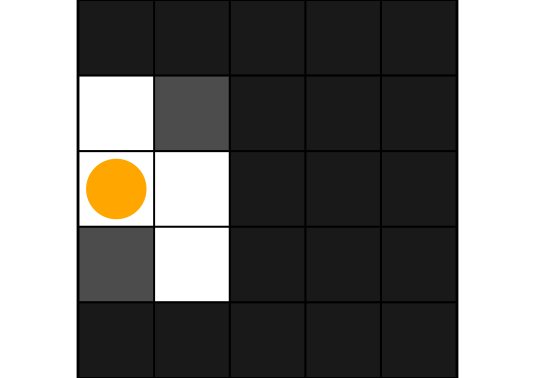

In [3]:
# one simulation step example
p0 = initialstate(gs) # initial state distribution
up = BootstrapFilter(gs, 100, rng)
b = ParticleCollection(support(initialize_belief(gs)))

s = rand(rng, p0) # initial state s ~ p0
o = rand(rng, observation(gs, s)) # observation o ~ O(s, a)

#plot the initial step
render(gs, (s=s,o=o))

In this 5x5 grid problem, white cells mean target zone, light gray cells mean shale zone, and dark gray cells mean harder rock, the darkest cells mean unobserved at this time step. The goal is to determine the sequence of drill directions (forward, top, or bottom) from orange circle location to other end of the target zone to reach the other end of the formation through drilling.

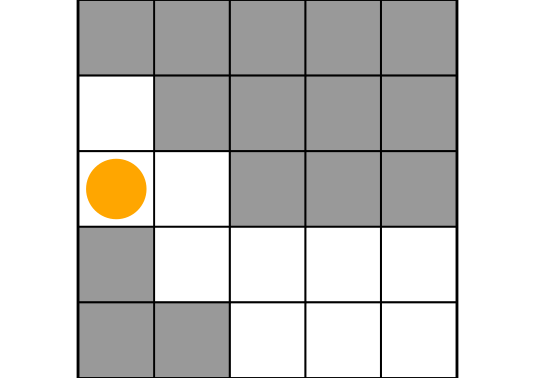

In [4]:
#plot the initial full rendering
render(pomdp2mdp(gs), (s=s,))

## MDP Model Components

### State Space

The state $s$ is the location (x, y) and surrounding cells.

In [5]:
𝒮 = states(gs)

#example of states
[println(𝒮[i]) for i in 1:3] 

println("The size of the state space is: ", length(𝒮))

State
  cell: SVector{2, Int64}
  is_surrounding_target: Dict{SVector{2, Int64}, Bool}

State
  cell: SVector{2, Int64}
  is_surrounding_target: Dict{SVector{2, Int64}, Bool}

State
  cell: SVector{2, Int64}
  is_surrounding_target: Dict{SVector{2, Int64}, Bool}

The size of the state space is: 650


### Action space

The action space is relatively small, with only 3 possible actions: move forward (`RIGHT`), `UP` or `DOWN`.

In [6]:
𝒜 = actions(gs)

(UP, DOWN, RIGHT)

### Transition function

The transition function in this problem is simple: whenever we take a drill action, we move toward the direction of that action with probability $1-p_\text{drift}$, and got drifted to random location with probability $p_\text{drift}$. However, we aren't able to go out of bounds of the system.

When transitioning to new locations, the surroundings status are also updated. We can simulate a state transition as follows.

In [7]:
# we can take random action from the action space

a = rand(rng, 𝒜) # random action
p = transition(gs, s, a) # get next state distribution p(s' | s, a)
sp = rand(rng, p) # the next state is sampled from this s ~ p

println("From state s with location ", s.cell, " and surrounding indicators (of being within formation/not):")
[println(key, ": ", value) for (key, value) in s.is_surrounding_target];
println("to state sp with location ", sp.cell, " and surroundings:")
[println(key, ": ", value) for (key, value) in sp.is_surrounding_target];

From state s with location [1, 3] and surrounding indicators (of being within formation/not):
[2, 3]: true
[0, 4]: false
[0, 2]: false
[2, 4]: false
[1, 4]: true
[2, 2]: true
[1, 2]: false
[0, 3]: false
to state sp with location [1, 4] and surroundings:
[0, 5]: false
[2, 3]: true
[0, 4]: false
[1, 3]: true
[2, 5]: false
[2, 4]: false
[1, 5]: false
[0, 3]: false


Had we taken an action RIGHT, we will have the following:

In [8]:
a_alt = DOWN
p_alt = transition(gs, s, a_alt) # get next state distribution p(s' | s, a)
sp_alt = rand(rng, p_alt) # the next state is sampled from this s ~ p

println("The new state sp with location ", sp.cell, " and surroundings:")
[println(key, ": ", value) for (key, value) in sp.is_surrounding_target];

The new state sp with location [1, 4] and surroundings:
[0, 5]: false
[2, 3]: true
[0, 4]: false
[1, 3]: true
[2, 5]: false
[2, 4]: false
[1, 5]: false
[0, 3]: false


### Reward Function

The reward function `reward(s,a)` or `reward(s,a,sp)` tells the reward we get if from state `s` we take an action `a` and end up at next state `sp`. 

In [9]:
r = reward(gs, s, a, sp)
println("The reward for taking action ", a, " from state ", s.cell, " and ending up in state ", sp.cell, " is ", r)

r_alt = reward(gs, s, a_alt, sp_alt)
println("The reward for taking action ", a_alt, " from state ", s.cell, " and ending up in state ", sp_alt.cell, " is ", r_alt)

The reward for taking action UP from state [1, 3] and ending up in state [1, 4] is 0.0
The reward for taking action DOWN from state [1, 3] and ending up in state [1, 2] is -100.0


### Comparing policies

With this model, we can try a bunch of approaches to come up with a policy. For POMDP, a policy is a mapping from belief to action. 

  1.953778 seconds (8.45 M allocations: 683.682 MiB, 5.23% gc time, 75.90% compilation time)
14 steps in the simulation
14 plots in the simulation
14 plots in the full rendering


┌ Info: Saved animation to /home/mansur/Work/MineralX/GeoSteerings.jl/figs/POMDPPolicy1_WithDrifting.gif
└ @ Plots /home/mansur/.julia/packages/Plots/du2dt/src/animation.jl:156


Plots.AnimatedGif("/home/mansur/Work/MineralX/GeoSteerings.jl/figs/POMDPPolicy1_WithDrifting.gif")
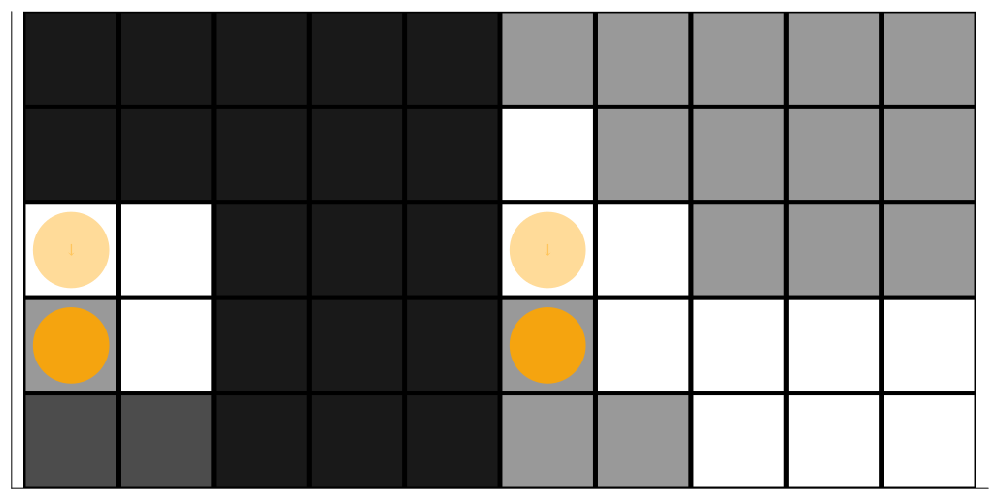

In [10]:
#random policy
rpolicy=RandomPolicy(gs)
policy_num=1

hr = HistoryRecorder(max_steps=30, rng=rng)
figs_dir = "../figs"

@time hist_ = simulate(hr, gs, rpolicy, up, b)

# plot and animate the simulation
plot_sim_steps = render(gs, hist_);
plot_sim_full = render(gs, hist_, full=true);

println(length(hist_), " steps in the simulation")
println(length(plot_sim_steps), " plots in the simulation")
println(length(plot_sim_full), " plots in the full rendering")

# for animation, we need pngs
# save the plots as png images 
base_img_sim = "SimRollout"
base_img_full = "FullRollout"
[savefig(plot_sim_steps[i], gs.size, joinpath(figs_dir, "$base_img_sim$i.png")) for i in 1:length(hist_)];
[savefig(plot_sim_full[i], gs.size, joinpath(figs_dir, "$base_img_full$i.png")) for i in 1:length(hist_)];

policy_name = string(rpolicy)
create_side_by_side_gif_from_images(
    dir=figs_dir, 
    img1_base=base_img_sim, 
    img2_base=base_img_full, 
    gif_name="POMDPPolicy$(policy_num)_WithDrifting.gif", 
    fps=1, num_steps=length(hist_)
    )

  3.038792 seconds (31.25 M allocations: 2.756 GiB, 6.25% gc time, 17.75% compilation time)
16 steps in the simulation
16 plots in the simulation
16 plots in the full rendering


┌ Info: Saved animation to /home/mansur/Work/MineralX/GeoSteerings.jl/figs/POMDPPolicy2_WithDrifting.gif
└ @ Plots /home/mansur/.julia/packages/Plots/du2dt/src/animation.jl:156


Plots.AnimatedGif("/home/mansur/Work/MineralX/GeoSteerings.jl/figs/POMDPPolicy2_WithDrifting.gif")
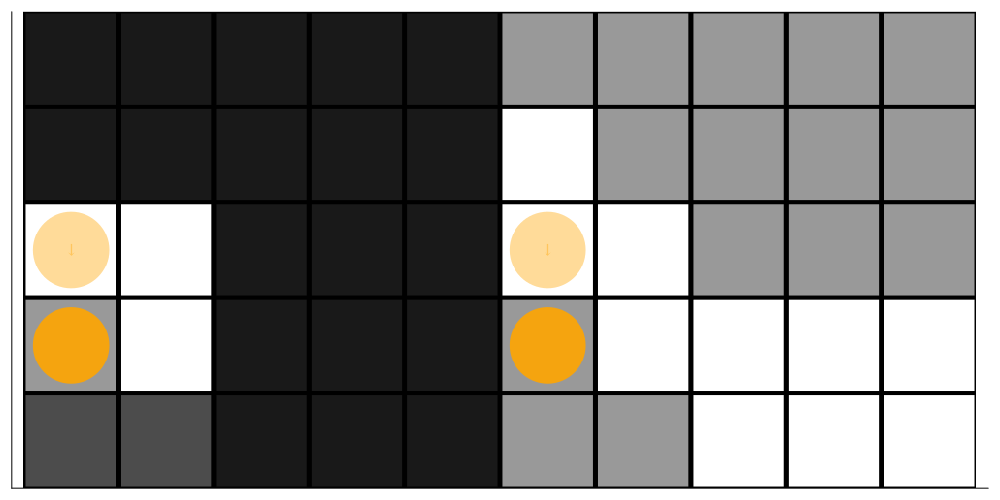

In [11]:
#online planner POMCPOW

solver = POMCPOWSolver(tree_queries=50,criterion=MaxUCB(100.0))
ppolicy = solve(solver, gs)
policy_num=2

@time hist_ = simulate(hr, gs, ppolicy, up, b)

# plot and animate the simulation
plot_sim_steps = render(gs, hist_);
plot_sim_full = render(gs, hist_, full=true);

println(length(hist_), " steps in the simulation")
println(length(plot_sim_steps), " plots in the simulation")
println(length(plot_sim_full), " plots in the full rendering")

# for animation, we need pngs
# save the plots as png images 
base_img_sim = "SimRollout"
base_img_full = "FullRollout"
[savefig(plot_sim_steps[i], gs.size, joinpath(figs_dir, "$base_img_sim$i.png")) for i in 1:length(hist_)];
[savefig(plot_sim_full[i], gs.size, joinpath(figs_dir, "$base_img_full$i.png")) for i in 1:length(hist_)];

policy_name = string(ppolicy)
create_side_by_side_gif_from_images(
    dir=figs_dir, 
    img1_base=base_img_sim, 
    img2_base=base_img_full, 
    gif_name="POMDPPolicy$(policy_num)_WithDrifting.gif", 
    fps=1, num_steps=length(hist_)
    )

 92.890850 seconds (1.12 G allocations: 99.705 GiB, 7.46% gc time, 0.85% compilation time)
11 steps in the simulation
11 plots in the simulation
11 plots in the full rendering


┌ Info: Saved animation to /home/mansur/Work/MineralX/GeoSteerings.jl/figs/POMDmpolicy3_WithDrifting.gif
└ @ Plots /home/mansur/.julia/packages/Plots/du2dt/src/animation.jl:156


Plots.AnimatedGif("/home/mansur/Work/MineralX/GeoSteerings.jl/figs/POMDmpolicy3_WithDrifting.gif")
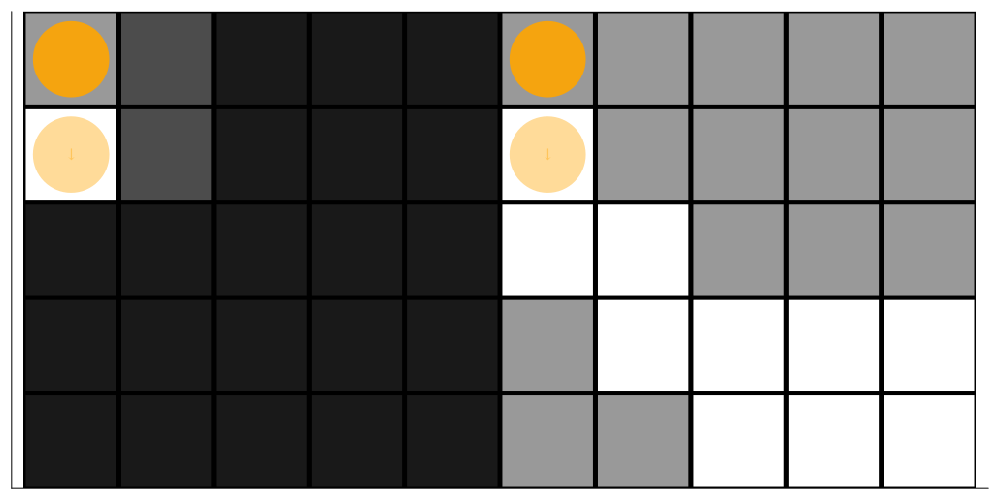

In [12]:
## online solver MCTS

mdp = GenerativeBeliefMDP(gs, up)    
msolver = DPWSolver(n_iterations=50, depth=gs.size[1], estimate_value=RolloutEstimator(rpolicy, max_depth=gs.size[1]))
mpolicy = solve(msolver, mdp)
policy_num=3

@time hist_ = simulate(hr, gs, mpolicy, up, b)

# plot and animate the simulation
plot_sim_steps = render(gs, hist_);
plot_sim_full = render(gs, hist_, full=true);

println(length(hist_), " steps in the simulation")
println(length(plot_sim_steps), " plots in the simulation")
println(length(plot_sim_full), " plots in the full rendering")

# for animation, we need pngs
# save the plots as png images 
base_img_sim = "SimRollout"
base_img_full = "FullRollout"
[savefig(plot_sim_steps[i], gs.size, joinpath(figs_dir, "$base_img_sim$i.png")) for i in 1:length(hist_)];
[savefig(plot_sim_full[i], gs.size, joinpath(figs_dir, "$base_img_full$i.png")) for i in 1:length(hist_)];

policy_name = string(mpolicy)
create_side_by_side_gif_from_images(
    dir=figs_dir, 
    img1_base=base_img_sim, 
    img2_base=base_img_full, 
    gif_name="POMDmpolicy$(policy_num)_WithDrifting.gif", 
    fps=1, num_steps=length(hist_)
    )